# 🧠 Income Classifier using Census Data
This project predicts whether an individual earns more than $50K per year using demographic data from the UCI Adult dataset: https://archive.ics.uci.edu/dataset/2/adult 

This mini project shows a basic machine learning pipeline: data cleaning, encoding, model training, and evaluation.

In [1]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [2]:
# Define column names based on data name file
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

df_train = pd.read_csv("/kaggle/input/census-income-dataset/adult.data", header=None, names=columns, na_values=" ?", skipinitialspace=True)
df_test = pd.read_csv("/kaggle/input/census-income-dataset/adult.test", header=0, names=columns, na_values=" ?", skipinitialspace=True, skiprows=1)
df_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


Drop all the NA values to make the dataset clean.

In [3]:
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train.dropna(inplace=True)

df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.dropna(inplace=True)

print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Training set shape: (32561, 15)
Test set shape: (16280, 15)


#### Encoding Categorical Features for Both Training and Test Sets

1. **Identify Categorical Columns:**  
   We select all columns of type `object` from the training set, except for the target column `income`.

2. **Fit & Transform Using LabelEncoder:**  
   For each categorical column:
   - We fit a `LabelEncoder` on the training data to create a mapping from text values to numbers.
   - We then transform **both** the training and test sets using the same mapping.  
     This ensures that the encoded values remain consistent between the two datasets.

3. **Encode the Target:**  
   We convert the `income` column into a binary variable:
   - `">50K"` becomes `1`
   - `"<=50K"` becomes `0`

In [4]:
cat_cols = df_train.select_dtypes(include="object").columns.drop("income")

for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

df_train["income"] = (df_train["income"] == ">50K").astype(int)
df_test["income"] = df_test["income"].str.replace(".", "", regex=False)
df_test["income"] = (df_test["income"] == ">50K").astype(int)

print(df_train.dtypes)

age               int64
workclass         int64
fnlwgt            int64
education         int64
education_num     int64
marital_status    int64
occupation        int64
relationship      int64
race              int64
sex               int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
native_country    int64
income            int64
dtype: object


# 📊 Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand the distribution of features and the relationship between them and the target variable (`income`). This helps identify patterns, trends, and potential issues before modeling.

## 💼 Income Class Distribution

We check whether the dataset is balanced between the two income classes (`<=50K` and `>50K`). This helps us understand potential bias or imbalance in the data.

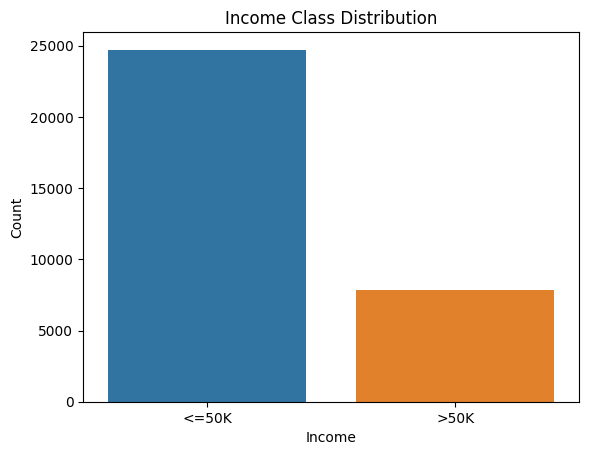

income
0    0.75919
1    0.24081
Name: proportion, dtype: float64

In [5]:
sns.countplot(x="income", data=df_train)
plt.title("Income Class Distribution")
plt.xticks([0, 1], ["<=50K", ">50K"])
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

df_train["income"].value_counts(normalize=True)

## 🔢 Distribution of Numeric Features

Histograms help visualize how each numeric feature is distributed. Features like `age`, `hours_per_week`, and `capital_gain` are often useful in predicting income.

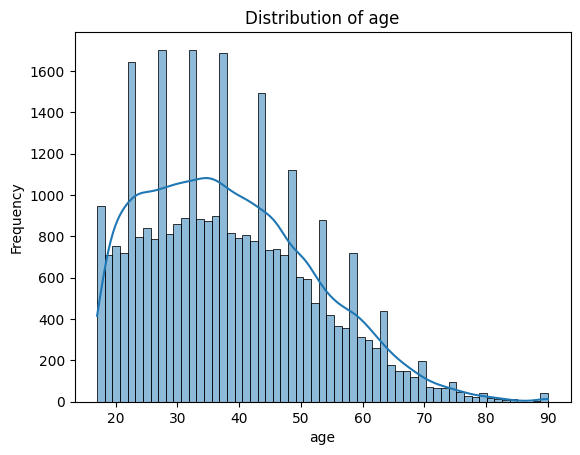

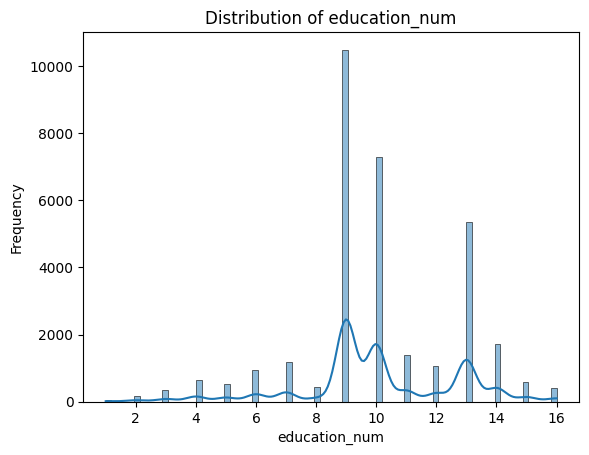

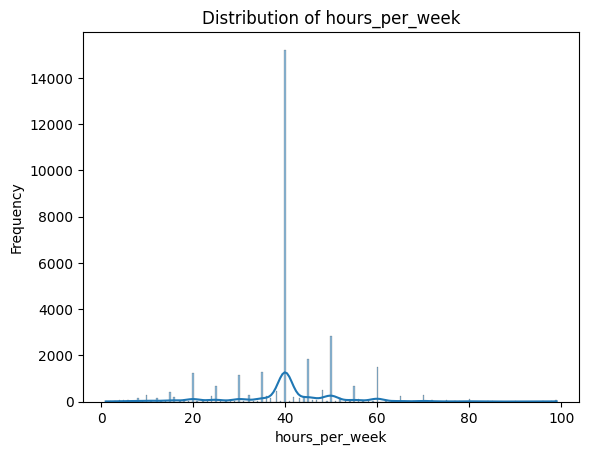

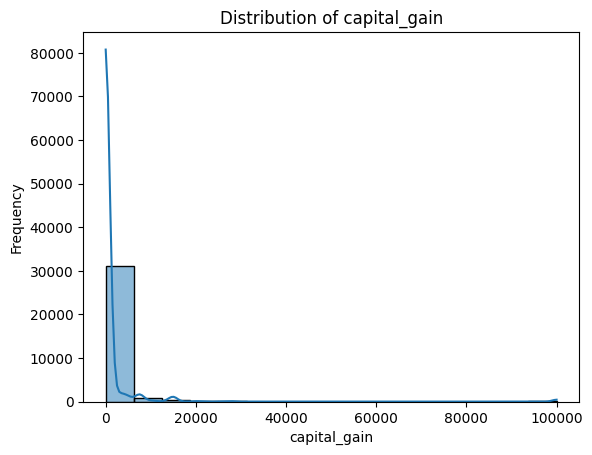

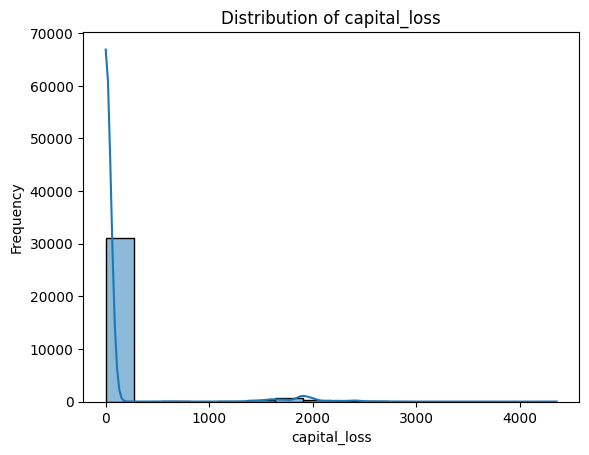

In [6]:
numeric_cols = ["age", "education_num", "hours_per_week", "capital_gain", "capital_loss"]

for col in numeric_cols:
    sns.histplot(df_train[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

## 🕒 Hours Worked vs Income

Boxplots can reveal how working hours differ across income levels. For example, people earning more than $50K may tend to work more hours per week.

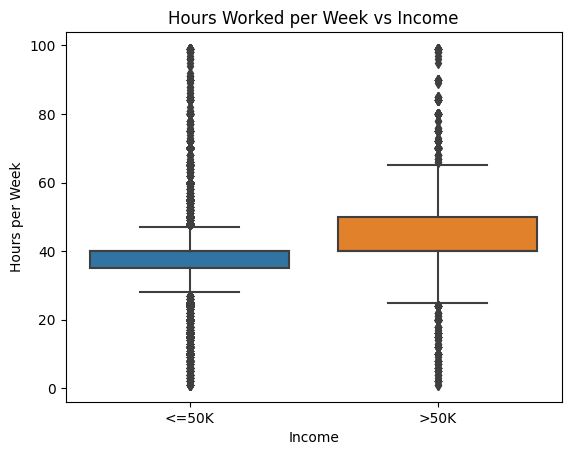

In [7]:
sns.boxplot(x="income", y="hours_per_week", data=df_train)
plt.title("Hours Worked per Week vs Income")
plt.xticks([0, 1], ["<=50K", ">50K"])
plt.xlabel("Income")
plt.ylabel("Hours per Week")
plt.show()

## 📌 Correlation Between Features

This heatmap shows the correlation between numeric features. Strongly correlated features can influence model performance and may require feature selection or engineering.

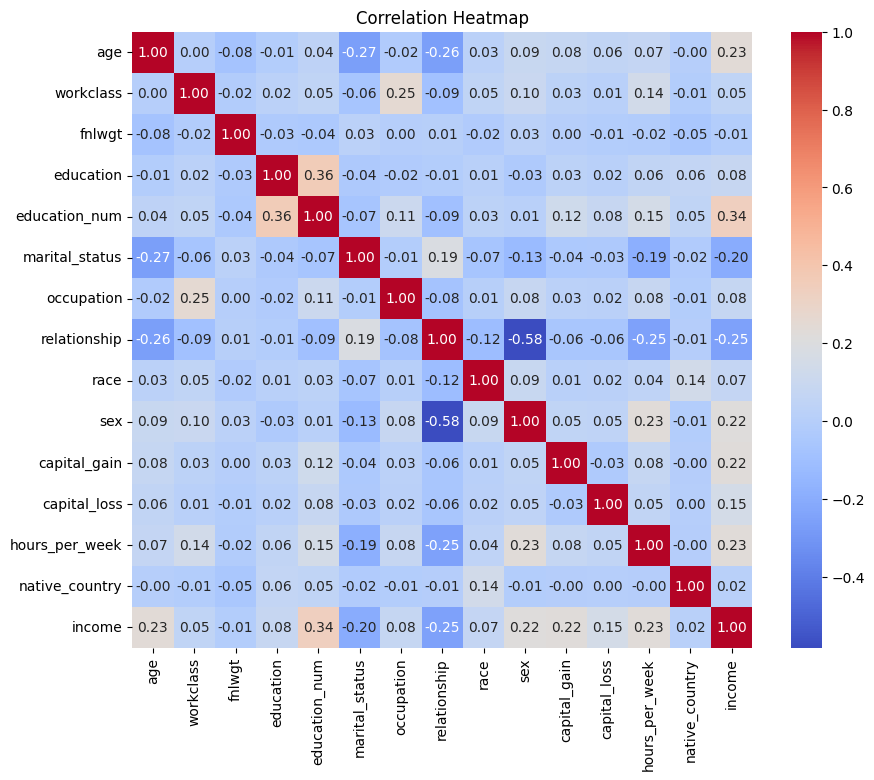

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## 📋 EDA Summary

- The dataset is imbalanced with more individuals earning <=50K.
- `age`, `education_num`, and `hours_per_week` show variation across income classes.
- `capital_gain` and `capital_loss` have long tails and many zeros.
- Some features like `education_num` are positively correlated with income, which may help improve model predictions.

# Splitting the Data into Training and Testing Sets

In [9]:
X_train = df_train.drop("income", axis=1)
y_train = df_train["income"]

X_test = df_test.drop("income", axis=1)
y_test = df_test["income"]

print(f"Training rows: {X_train.shape[0]}, Test rows: {X_test.shape[0]}")

Training rows: 32561, Test rows: 16280


# Model Building
## Random Forest

In [10]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred_rf = clf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     12434
           1       0.73      0.61      0.67      3846

    accuracy                           0.86     16280
   macro avg       0.81      0.77      0.79     16280
weighted avg       0.85      0.86      0.85     16280



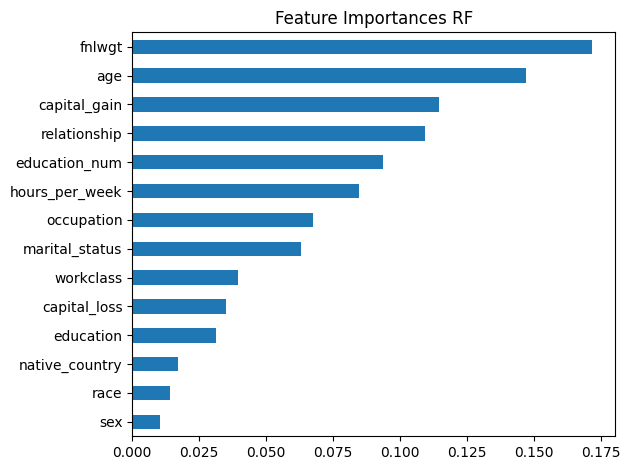

In [11]:
# Feature Importances
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind="barh", title="Feature Importances RF")
plt.tight_layout()
plt.show()

## XGBoost 

In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results:\n")
print(classification_report(y_test, y_pred_xgb))

XGBoost Results:

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12434
           1       0.76      0.66      0.71      3846

    accuracy                           0.87     16280
   macro avg       0.83      0.80      0.81     16280
weighted avg       0.87      0.87      0.87     16280



# Hyperparameter tuning - GridSearchCV

In [13]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Calculate the imbalance ratio from y_train
imbalance_ratio = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_base = XGBClassifier(
    scale_pos_weight=imbalance_ratio,
    use_label_encoder=False,
    eval_metric='logloss'
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV F1 score:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_xgbgrid = best_model.predict(X_test)

print(classification_report(y_test, y_pred_xgbgrid))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV F1 score: 0.7171725303021853
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     12434
           1       0.61      0.86      0.71      3846

    accuracy                           0.84     16280
   macro avg       0.78      0.84      0.80     16280
weighted avg       0.87      0.84      0.85     16280



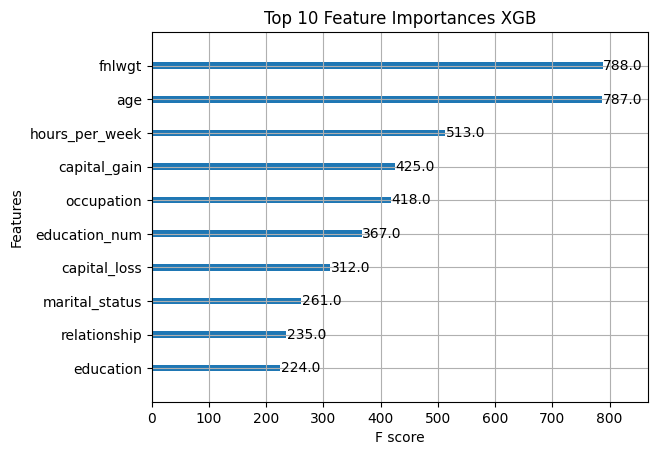

In [14]:
plot_importance(best_model, max_num_features=10)  
plt.title("Top 10 Feature Importances XGB")
plt.show()

## LightGBM

In [15]:
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print("LightGBM:")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 7841, number of negative: 24720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 32561, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88     12434
           1       0.61      0.86      0.71      3846

    accuracy                           0.84     16280
   macro avg       0.78      0.85      0.80     16280
weighted avg       0.87      0.84      0.84     16280



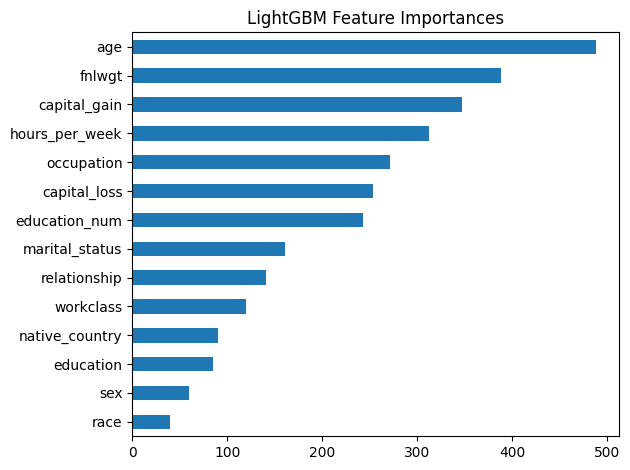

In [16]:
lgb_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
lgb_importance.sort_values().plot(kind="barh", title="LightGBM Feature Importances")
plt.tight_layout()
plt.show()

## SVM

In [17]:
svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM:")
print(classification_report(y_test, y_pred_svm))

SVM:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88     12434
           1       0.84      0.19      0.31      3846

    accuracy                           0.80     16280
   macro avg       0.82      0.59      0.60     16280
weighted avg       0.81      0.80      0.75     16280



# Stacking

In [18]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgb', lgb.LGBMClassifier())
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3
)

stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)

print("Stacking Ensemble Performance:")
print(classification_report(y_test, y_pred_stack))

[LightGBM] [Info] Number of positive: 7841, number of negative: 24720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 32561, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240810 -> initscore=-1.148246
[LightGBM] [Info] Start training from score -1.148246
[LightGBM] [Info] Number of positive: 5227, number of negative: 16480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 21707, number of used features: 14
[LightGBM] [Info] [bin

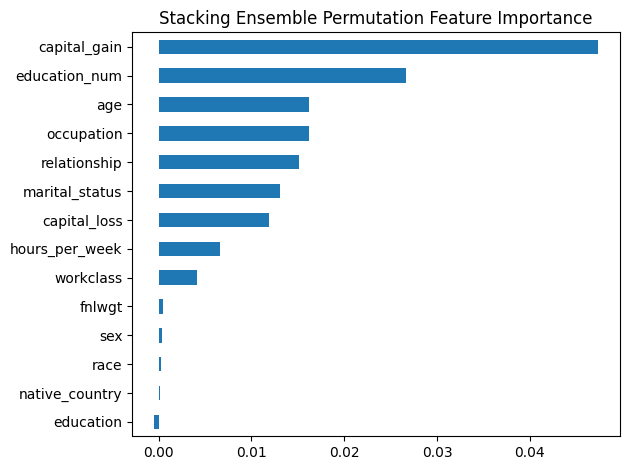

In [19]:
result_stack = permutation_importance(stack_model, X_test, y_test, n_repeats=10)
stack_importance = pd.Series(result_stack.importances_mean, index=X_test.columns)
stack_importance.sort_values().plot(kind="barh", title="Stacking Ensemble Permutation Feature Importance")
plt.tight_layout()
plt.show()

# ✅ Conclusion

WIP